<h2><center> <font color='black'> Graph Embeddings</font></center></h3>

================================================================================================================


+ **Graph Embeddings**
  1. DeepWalk<br>
      1.1 DeepWalk Basics<br>
      1.2 Visualization of DeepWalk Embeddings<br>
  2. Node2Vec<br>
      2.1 Node2Vec Basics<br>
      2.2 Use case: Node embeddings for Clustering


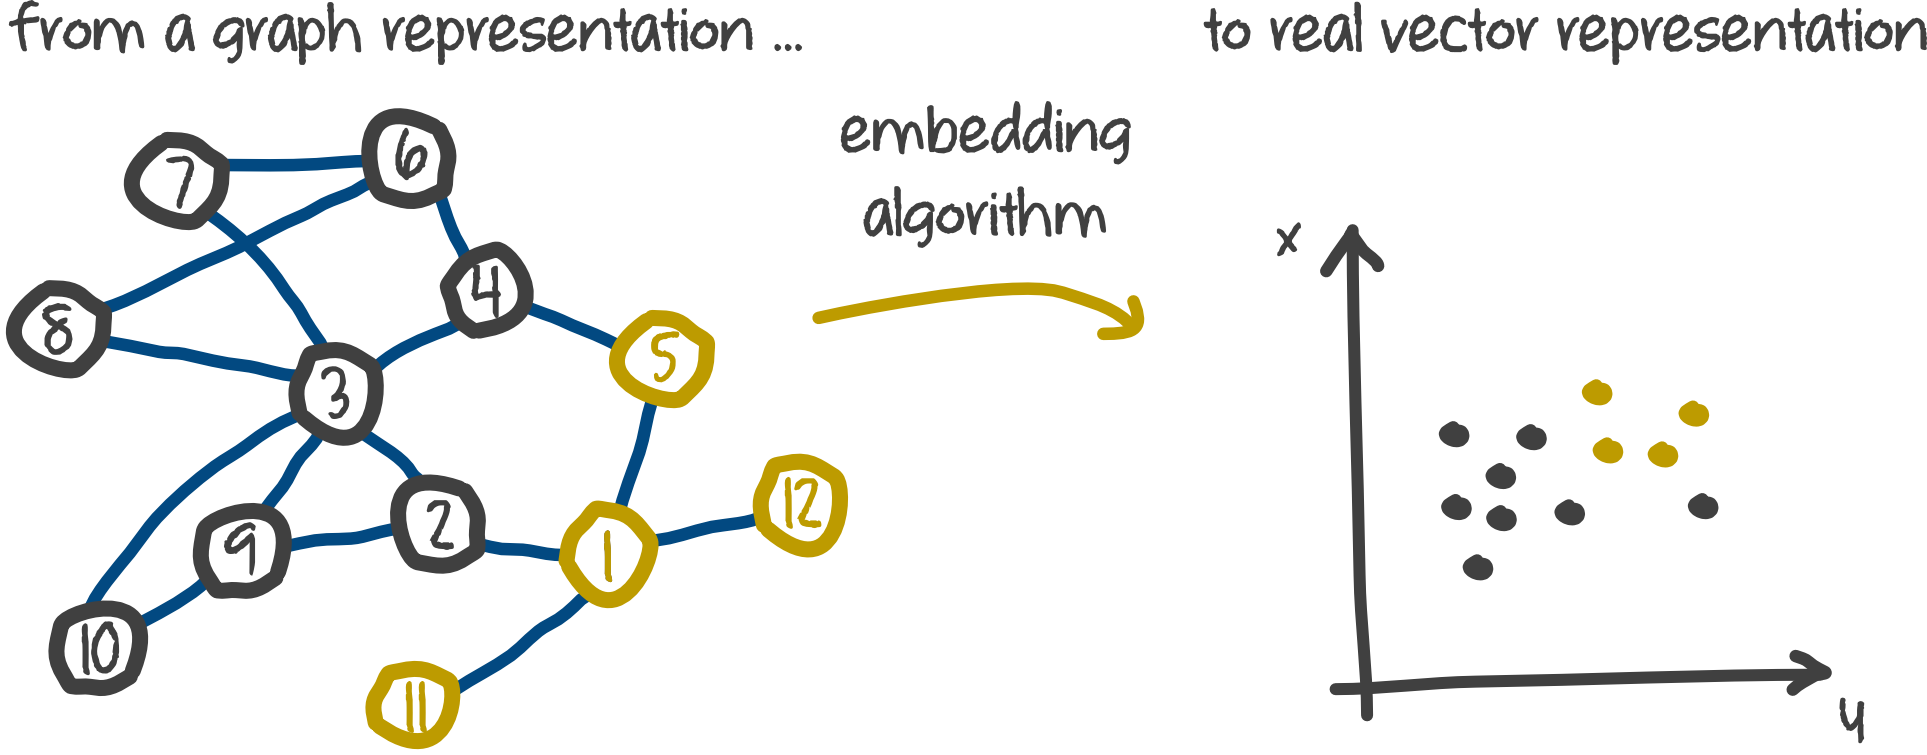

In [ ]:
from IPython.display import Image
Image("graph_embedding.png")

# Graph Embeddings: 
Graph embedding is an approach that is used to transform nodes, edges, and their features into vector space (a lower dimension) whilst maximally preserving properties like graph structure and information.<br>
**1. DeepWalk:**<br>
DeepWalk is an algorithm that is used to create embeddings of the nodes in a graph. The embeddings are meant to encode the community structure of the graph. It achieves this by using SkipGram to create the embeddings. It uses short random walks to learn representations for vertices in graphs.DeepWalk implementation - https://github.com/prateekjoshi565/DeepWalk, http://www.perozzi.net/projects/deepwalk/<br>
**2. NodeVec:**<br>
The node2vec framework learns low-dimensional representations for nodes in a graph by optimizing a neighborhood preserving objective. The objective is flexible, and the algorithm accomodates for various definitions of network neighborhoods by simulating biased random walks. Specifically, it provides a way of balancing the exploration-exploitation tradeoff that in turn leads to representations obeying a spectrum of equivalences from homophily to structural equivalence. Node2Vec implementation - https://github.com/eliorc/node2vec, https://github.com/aditya-grover/node2vec

# 1. DeepWalk:

## Libraries needed

**We need following libraries: networkx, Word2Vec, PCA**

In [ ]:
import networkx as nx
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
%matplotlib inline
from gensim.models import Word2Vec

import warnings
warnings.filterwarnings('ignore')

## Loading Dataset:

In [ ]:
# Import the karate club csv file where edge list is stored (separated by space)
edge_list = pd.read_csv("karate_edgelist.csv", sep = ' ', header = None)

In [ ]:
# check first five rows of the dataframe
edge_list.head()

,0,1
0,1,32
1,1,22
2,1,20
3,1,18
4,1,14


In [ ]:
# rename columns of the dataframe
edge_list.rename(columns = {0:'source', 1: 'target'}, inplace = True)

In [ ]:
edge_list.head()

,source,target
0,1,32
1,1,22
2,1,20
3,1,18
4,1,14


In [ ]:
# convert integers into string
edge_list = edge_list.applymap(str)

## Creation of graph

In [ ]:
# create undirected graph from the edgelist
G=nx.from_pandas_edgelist(edge_list, source='source', target='target', create_using=nx.Graph())

In [ ]:
# check the basic properties of the graph
nx.info(G)

'Name: \nType: Graph\nNumber of nodes: 34\nNumber of edges: 77\nAverage degree:   4.5294'

In [ ]:
G.nodes

NodeView(('1', '32', '22', '20', '18', '14', '13', '12', '11', '9', '8', '7', '6', '5', '4', '3', '2', '31', '10', '33', '29', '28', '17', '34', '15', '16', '19', '21', '23', '24', '30', '26', '25', '27'))

## 1.1 Deep Walk Basics

### Random Walk

In [ ]:
# function to generate random walk sequences of nodes for a particular node
def get_random_walk(node, walk_length):
    # initialization
    random_walk_length = [node]
    
    #loop over to get the nodes visited in a random walk
    for i in range(walk_length-1):
        # list of neighbors
        neighbors = list(G.neighbors(node))
        # if the same neighbors are present in ranom_walk_length list, then donot add them as new neighbors
        neighbors = list(set(neighbors) - set(random_walk_length))    
        if len(neighbors) == 0:
            break
        # pick any one neighbor randomly from the neighbors list
        random_neighbor = random.choice(neighbors)
        # append that random_neighbor to the random_walk_length list
        random_walk_length.append(random_neighbor)
        node = random_neighbor
        
    return random_walk_length

In [ ]:
# check random walk for node '2'
get_random_walk('2', 10)

['2', '3', '1', '8', '4', '14', '34', '19', '33', '23']

In [ ]:
# calculate random walks for every node in the Graph
all_nodes = list(G.nodes())
number_of_random_walks = 5
random_walks = []

for node in tqdm(all_nodes):
    # number of random walks
    for i in range(number_of_random_walks):
        # append the random walk sequence of a node from a specified length
        random_walks.append(get_random_walk(node, 10))

100%|█████████████| 34/34 [00:00<00:00, 3432.91it/s]


In [ ]:
len(random_walks)

170

In [ ]:
random_walks[0]

['1', '2', '3', '14', '34', '23', '33', '31']

In [ ]:
random_walks[1]

['1', '3', '4', '2', '18']

In [ ]:
# train word2vec model
model = Word2Vec(window = 4, sg = 1, hs = 0,
                 negative = 10, # for negative sampling
                 alpha=0.03, min_alpha=0.0007,
    )

model.build_vocab(random_walks, progress_per=2)

In [ ]:
model.train(random_walks, total_examples = model.corpus_count, epochs=20, report_delay=1)

(5818, 27700)

In [ ]:
print(model)

Word2Vec(vocab=34, size=100, alpha=0.03)


## Most similar nodes

In [ ]:
# most similar nodes to node '1'
for node, _ in model.most_similar('1'):
    print((node, _))

('8', 0.9996576309204102)
('13', 0.9996277093887329)
('11', 0.9995778799057007)
('22', 0.9995776414871216)
('5', 0.9995756149291992)
('20', 0.9995747208595276)
('14', 0.999564528465271)
('18', 0.9995552897453308)
('16', 0.9995509386062622)
('6', 0.9995485544204712)


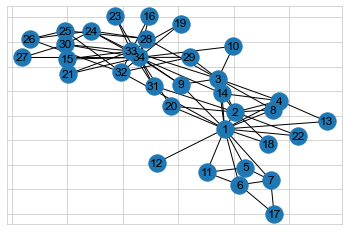

In [ ]:
nx.draw_networkx(G)

## 1.2 Visualization of DeepWalk Embeddings

In [ ]:
def plot_nodes(word_list):
    X = model[word_list]
    
    # reduce dimensions to 2
    pca = PCA(n_components=2)
    result = pca.fit_transform(X)
    
    
    plt.figure(figsize=(12,9))
    # create a scatter plot of the projection
    plt.scatter(result[:, 0], result[:, 1])
    for i, word in enumerate(word_list):
        plt.annotate(word, xy=(result[i, 0], result[i, 1]))
        
    plt.show()

In [ ]:
numbers = list(G.nodes)

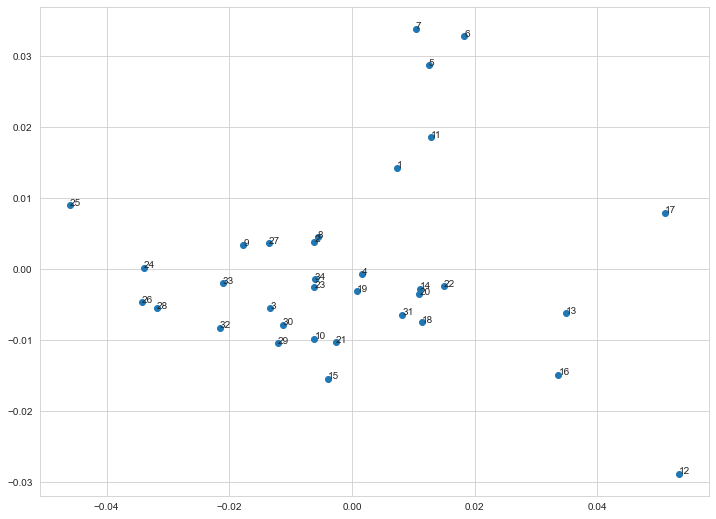

In [ ]:
plot_nodes(numbers)

# 2. Node2Vec:

## Libraries needed

**We need following libraries: networkx, Node2Vec, TSNE, text-unidecode**

In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from node2vec import Node2Vec


## Loading Dataset

In [ ]:
# import the karate club csv file where edge list is stored (separated by space)
edge_list = pd.read_csv("karate_edgelist.csv", sep = ' ', header = None)

In [ ]:
# check first five rows of the dataframe
edge_list.head()

,0,1
0,1,32
1,1,22
2,1,20
3,1,18
4,1,14


In [ ]:
# rename columns of the dataframe
edge_list.rename(columns = {0:'source', 1: 'target'}, inplace = True)

In [ ]:
# check shape of the dataframe
edge_list.shape

(78, 2)

In [ ]:
# create undirected graph from the edgelist
G=nx.from_pandas_edgelist(edge_list, source='source', target='target', create_using=nx.Graph())

In [ ]:
# check the basic properties of the graph
nx.info(G)

'Name: \nType: Graph\nNumber of nodes: 34\nNumber of edges: 77\nAverage degree:   4.5294'

In [ ]:
# Get the names of the nodes
G.nodes

NodeView((1, 32, 22, 20, 18, 14, 13, 12, 11, 9, 8, 7, 6, 5, 4, 3, 2, 31, 10, 33, 29, 28, 17, 34, 15, 16, 19, 21, 23, 24, 30, 26, 25, 27))

# 2.1 Node2Vec Basics

In [ ]:
# Precompute probabilities and generate walks - **ON WINDOWS ONLY WORKS WITH workers=1**
node2vec = Node2Vec(G, dimensions=128, walk_length=40, num_walks=100, workers=2)

In [ ]:
# Embed nodes
model = node2vec.fit(window=10, min_count=1)

## Retreive the dimension of a particular node

In [ ]:
# Get the vector of node '1'
model.wv.get_vector('1')

array([-0.06021162,  0.05920438,  0.13541238, -0.1576527 , -0.04560728,
        0.08010139, -0.10788777, -0.12199755,  0.32306507, -0.01685208,
        0.0307502 , -0.00746491,  0.00839918, -0.14373285,  0.15237056,
       -0.11468939, -0.07247932, -0.07777714,  0.18390231, -0.06012971,
        0.030331  ,  0.13590679, -0.11650144, -0.02011384, -0.1552805 ,
        0.03276515, -0.12344512, -0.07220475,  0.08725736, -0.1852314 ,
       -0.07590257,  0.00638197, -0.10279389,  0.14863501, -0.12409803,
       -0.03663852, -0.02603118, -0.00553788, -0.03561167,  0.04750277,
       -0.15634243, -0.00094674,  0.0689159 , -0.00218854,  0.13952787,
        0.11479674,  0.10144193, -0.20202757,  0.07500755, -0.00141453,
        0.17852788, -0.0044883 ,  0.05342088,  0.00326298, -0.08844239,
       -0.03216313, -0.00211309, -0.04687908, -0.03796275,  0.06312978,
       -0.0536274 , -0.04375061, -0.01998333,  0.11210432,  0.10422377,
        0.07880934, -0.0793282 ,  0.05623085, -0.08138434,  0.15

## Most similar nodes to a particular node

In [ ]:
# most similar nodes to node '1'
for node, _ in model.most_similar('1'):
    print((node, _))

('11', 0.7953322529792786)
('12', 0.7757797241210938)
('5', 0.7693582773208618)
('7', 0.7654445171356201)
('6', 0.7444137930870056)
('2', 0.7434602379798889)
('18', 0.7346737384796143)
('14', 0.7207126021385193)
('13', 0.6969244480133057)
('8', 0.6934106945991516)


## Verify the similar nodes using networkx graph

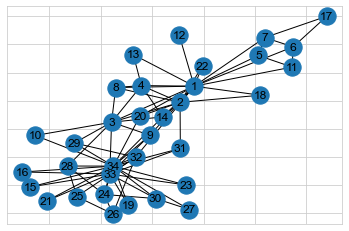

In [ ]:
# verify the most similar nodes generated by node2vec from the graph
nx.draw_networkx(G)

## Save the embeddings and the trained model 

In [ ]:
# save the node embeddings
model.wv.save_word2vec_format('embedding.csv')

In [ ]:
# save the model for later use (useful when node2Vec takes lots of time/memory to generate node embeddings)
model.save('model')

## Retreive all the nodes' embeddings

In [ ]:
# Retrieve node embeddings
node_ids = model.wv.index2word  # list of node IDs
node_embeddings = model.wv.vectors

In [ ]:
print(node_ids)
print(node_embeddings)

['34', '1', '33', '3', '2', '32', '4', '24', '14', '6', '7', '8', '30', '28', '9', '25', '26', '11', '20', '5', '29', '31', '17', '22', '18', '19', '27', '15', '10', '16', '21', '13', '23', '12']
[[-0.03333927 -0.15885349 -0.11985876 ... -0.28665787 -0.12117267
   0.04955142]
 [-0.06021162  0.05920438  0.13541238 ... -0.17544663 -0.03768142
  -0.00443627]
 [ 0.05801437 -0.16430196 -0.07288866 ... -0.32210723 -0.1239003
   0.04720712]
 ...
 [-0.07101642  0.00402015  0.01311063 ...  0.00266819 -0.04468243
  -0.05103849]
 [ 0.08452843 -0.18824401 -0.10931572 ... -0.30335745 -0.1180018
   0.08515   ]
 [-0.01357927 -0.00660213  0.08050326 ... -0.06099131 -0.02501993
  -0.09497296]]


# 2.2 Use case: Node embeddings for Clustering
Embeddings can be used in various downstream tasks such as Classification, Link Prediction, etc.

### Reference: https://towardsdatascience.com/node2vec-embeddings-for-graph-data-32a866340fef
### TSNE link -https://www.youtube.com/watch?v=NEaUSP4YerM&t=144s&ab_channel=StatQuestwithJoshStarmer

In [ ]:
#!pip install text-unidecode
#!pip install tsne

In [ ]:
import warnings
from text_unidecode import unidecode
from collections import deque
warnings.filterwarnings('ignore')
from sklearn.manifold import TSNE
import matplotlib.patches as mpatches
import seaborn as sns

sns.set_style('whitegrid')

## Load data 

In [ ]:
data = pd.read_csv('Football_data.csv', usecols=['Name', 'Club', 'Club_Position', 'Rating'])

## Pre-processing steps


In [ ]:
# Lowercase columns for convenience
data.columns = list(map(str.lower, data.columns))

# Reformat strings: lowercase, ' ' -> '_' and é, ô etc. -> e, o
reformat_string = lambda x: unidecode(str.lower(x).replace(' ', '_'))
    
data['name'] = data['name'].apply(reformat_string)
data['club'] = data['club'].apply(reformat_string)

# Lowercase position
data['club_position'] = data['club_position'].str.lower()

# Ignore substitutes and reserves 
data = data[(data['club_position'] != 'sub') & (data['club_position'] != 'res')]

# Fix lcm rcm -> cm cm
fix_positions = {'rcm' : 'cm', 'lcm': 'cm', 'rcb': 'cb', 'lcb': 'cb', 'ldm': 'cdm', 'rdm': 'cdm'}
data['club_position'] = data['club_position'].apply(lambda x: fix_positions.get(x, x))

# For example sake we will keep only 7 clubs
clubs = {'real_madrid', 'manchester_utd', 
         'manchester_city', 'chelsea', 'juventus', 
         'fc_bayern', 'napoli'}

data = data[data['club'].isin(clubs)]


# Verify we have 11 player for each team
assert all(n_players == 11 for n_players in data.groupby('club')['name'].nunique())

data

,name,club,club_position,rating
0,cristiano_ronaldo,real_madrid,lw,94
4,manuel_neuer,fc_bayern,gk,92
5,de_gea,manchester_utd,gk,90
6,robert_lewandowski,fc_bayern,st,90
7,gareth_bale,real_madrid,rw,90
...,...,...,...,...
615,marcos_alonso,chelsea,lwb,79
687,gael_clichy,manchester_city,lb,79
850,victor_moses,chelsea,rwb,78
892,willy_caballero,manchester_city,gk,78


## Formations of the teams

In [ ]:
FORMATIONS = {'4-3-3_4': {'gk': ['cb_1', 'cb_2'],                           # Real madrid
                          'lb': ['lw', 'cb_1', 'cm_1'],
                          'cb_1': ['lb', 'cb_2', 'gk'],
                          'cb_2': ['rb', 'cb_1', 'gk'],
                          'rb': ['rw', 'cb_2', 'cm_2'],
                          'cm_1': ['cam', 'lw', 'cb_1', 'lb'],
                          'cm_2': ['cam', 'rw', 'cb_2', 'rb'],
                          'cam': ['cm_1', 'cm_2', 'st'],
                          'lw': ['cm_1', 'lb', 'st'],
                          'rw': ['cm_2', 'rb', 'st'],
                          'st': ['cam', 'lw', 'rw']},
              '5-2-2-1': {'gk': ['cb_1', 'cb_2', 'cb_3'],                   # Chelsea
                          'cb_1': ['gk', 'cb_2', 'lwb'],
                          'cb_2': ['gk', 'cb_1', 'cb_3', 'cm_1', 'cb_2'],
                          'cb_3': ['gk', 'cb_2', 'rwb'],
                          'lwb': ['cb_1', 'cm_1', 'lw'],
                          'cm_1': ['lwb', 'cb_2', 'cm_2', 'lw', 'st'],
                          'cm_2': ['rwb', 'cb_2', 'cm_1', 'rw', 'st'],
                          'rwb': ['cb_3', 'cm_2', 'rw'],
                          'lw': ['lwb', 'cm_1', 'st'],
                          'st': ['lw', 'cm_1', 'cm_2', 'rw'],
                          'rw': ['st', 'rwb', 'cm_2']},
              '4-3-3_2': {'gk': ['cb_1', 'cb_2'],                           # Man UTD / CITY
                          'lb': ['cb_1', 'cm_1'],
                          'cb_1': ['lb', 'cb_2', 'gk', 'cdm'],
                          'cb_2': ['rb', 'cb_1', 'gk', 'cdm'],
                          'rb': ['cb_2', 'cm_2'],
                          'cm_1': ['cdm', 'lw', 'lb', 'st'],
                          'cm_2': ['cdm', 'rw', 'st', 'rb'],
                          'cdm': ['cm_1', 'cm_2', 'cb_1', 'cb_2'],
                          'lw': ['cm_1', 'st'],
                          'rw': ['cm_2', 'st'],
                          'st': ['cm_1', 'cm_2', 'lw', 'rw']},              # Juventus, Bayern
                            '4-2-3-1_2': {'gk': ['cb_1', 'cb_2'],
                            'lb': ['lm', 'cdm_1', 'cb_1'],
                            'cb_1': ['lb', 'cdm_1', 'gk', 'cb_2'],
                            'cb_2': ['rb', 'cdm_2', 'gk', 'cb_1'],
                            'rb': ['cb_2', 'rm', 'cdm_2'],
                            'lm': ['lb', 'cdm_1', 'st', 'cam'],
                            'rm': ['rb', 'cdm_2', 'st', 'cam'],
                            'cdm_1': ['lm', 'cb_1', 'rb', 'cam'],
                            'cdm_2': ['rm', 'cb_2', 'lb', 'cam'],
                            'cam': ['cdm_1', 'cdm_2', 'rm', 'lm', 'st'],
                            'st': ['lm', 'rm', 'cam']},
              '4-3-3': {'gk': ['cb_1', 'cb_2'],                             # Napoli
                        'lb': ['cb_1', 'cm_1'],
                        'cb_1': ['lb', 'cb_2', 'gk', 'cm_2'],
                        'cb_2': ['rb', 'cb_1', 'gk', 'cm_2'],
                        'rb': ['cb_2', 'cm_3'],
                        'cm_1': ['cm_2', 'lw', 'lb'],
                        'cm_3': ['cm_2', 'rw', 'rb'],
                        'cm_2': ['cm_1', 'cm_3', 'st', 'cb_1', 'cb_2'],
                        'lw': ['cm_1', 'st'],
                        'rw': ['cm_3', 'st'],
                        'st': ['cm_2', 'lw', 'rw']}}

## Creation of graph

In [ ]:
add_club_suffix = lambda x, c: x + '_{}'.format(c)

graph = nx.Graph()
formatted_positions = set()

def club2graph(club_name, formation, graph):
    club_data = data[data['club'] == club_name]
    
    club_formation = FORMATIONS[formation]
    
    club_positions = dict()
    
    # Assign positions to players
    available_positions = deque(club_formation)
    available_players = set(zip(club_data['name'], club_data['club_position']))
    
    roster = dict()  # Here we will store the assigned players and positions
    
    while available_positions:
        position = available_positions.pop()
        name, pos = [(name, position) for name, p in available_players if position.startswith(p)][0]        
        
        roster[name] = pos
        
        available_players.remove((name, pos.split('_')[0]))
        
    reverse_roster = {v: k for k, v in roster.items()}
    # Build the graph
    for name, position in roster.items():
        # Connect to team name
        graph.add_edge(name, club_name)
        
        # Inter team connections
        for teammate_position in club_formation[position]:
            # Connect positions
            graph.add_edge(add_club_suffix(position, club_name),
                           add_club_suffix(teammate_position, club_name))
            
            # Connect player to teammate positions
            graph.add_edge(name,
                           add_club_suffix(teammate_position, club_name))
            
            # Connect player to teammates
            graph.add_edge(name, reverse_roster[teammate_position])
            
            # Save for later trimming
            formatted_positions.add(add_club_suffix(position, club_name))
            formatted_positions.add(add_club_suffix(teammate_position, club_name))
            
    return graph

### Graph Structure

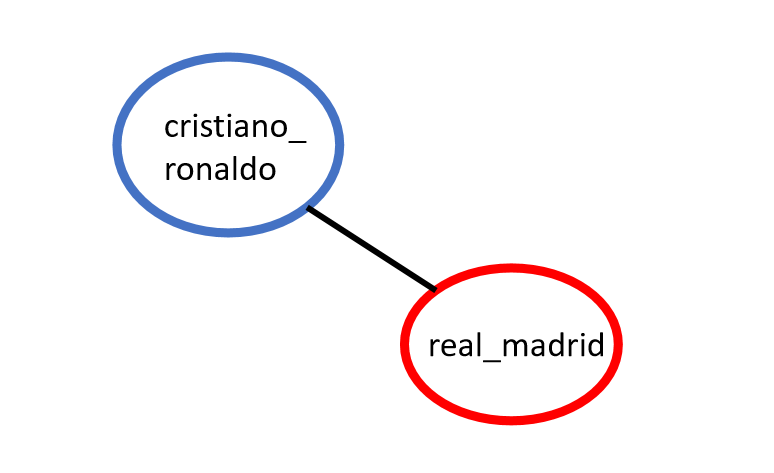

In [ ]:
from IPython.display import Image
#Image("Football1.png")

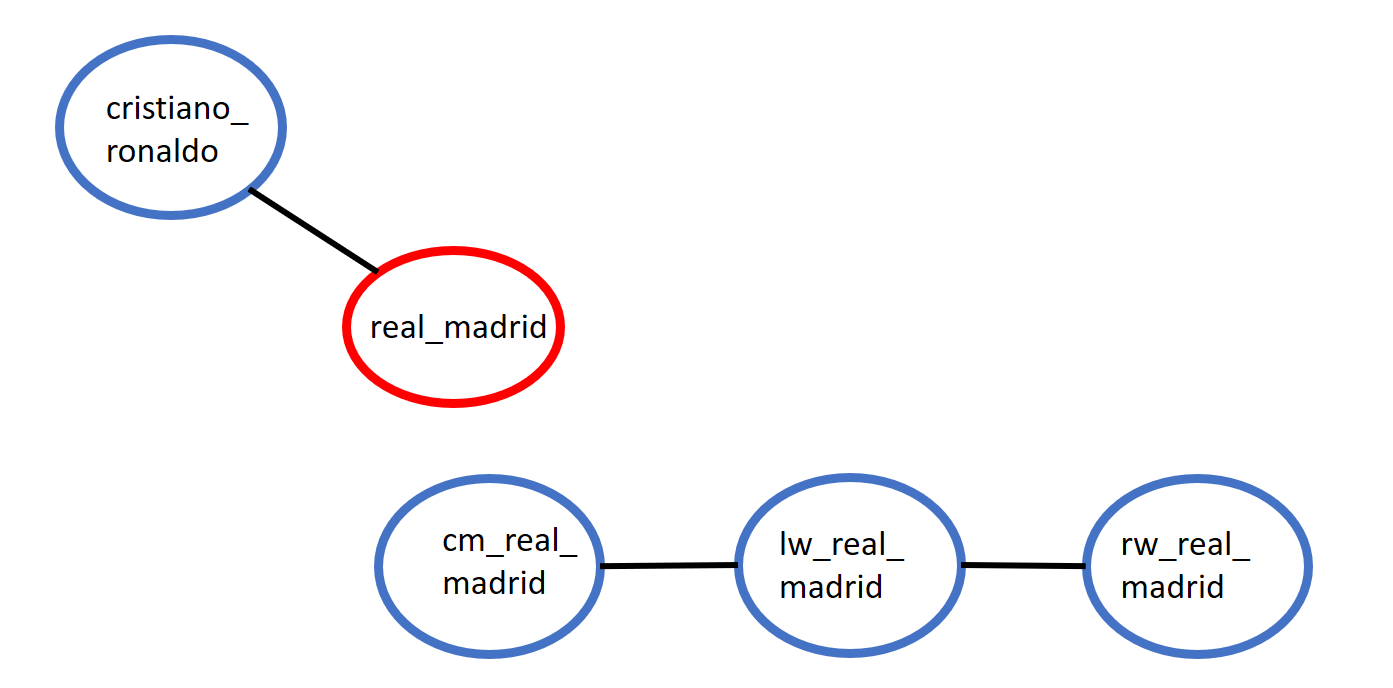

In [ ]:
#Image("Football2.png")

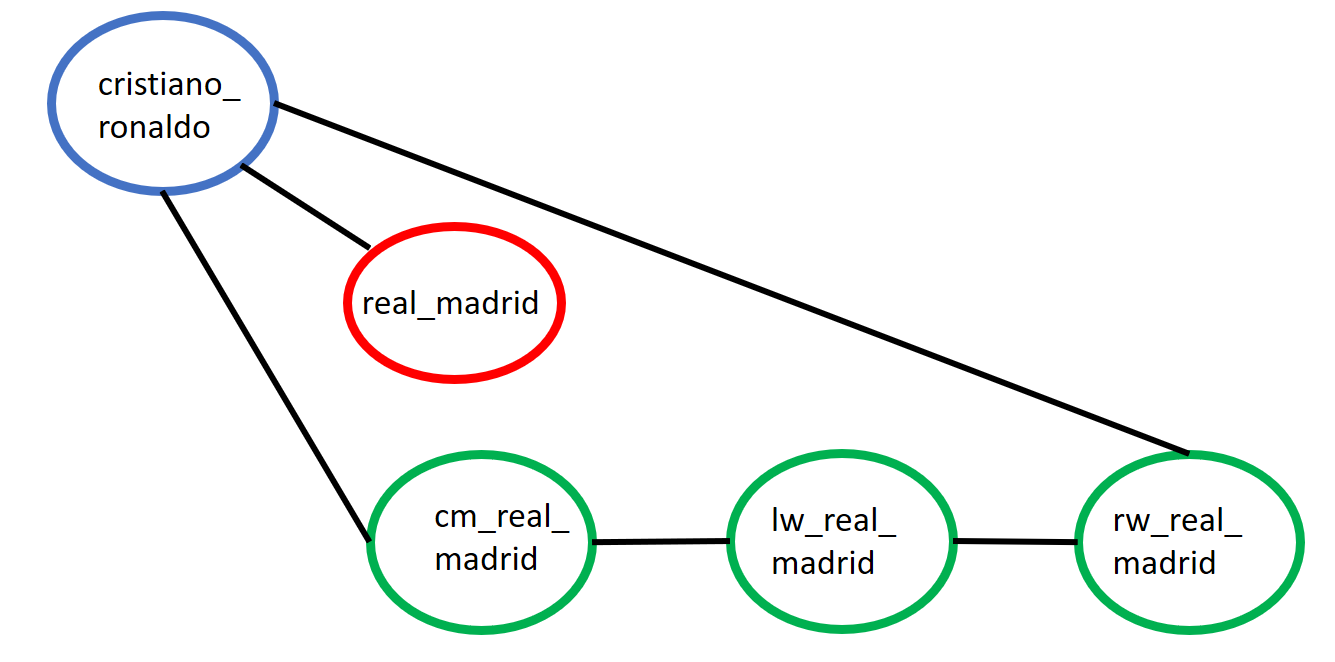

In [ ]:
#Image("Football3.png")

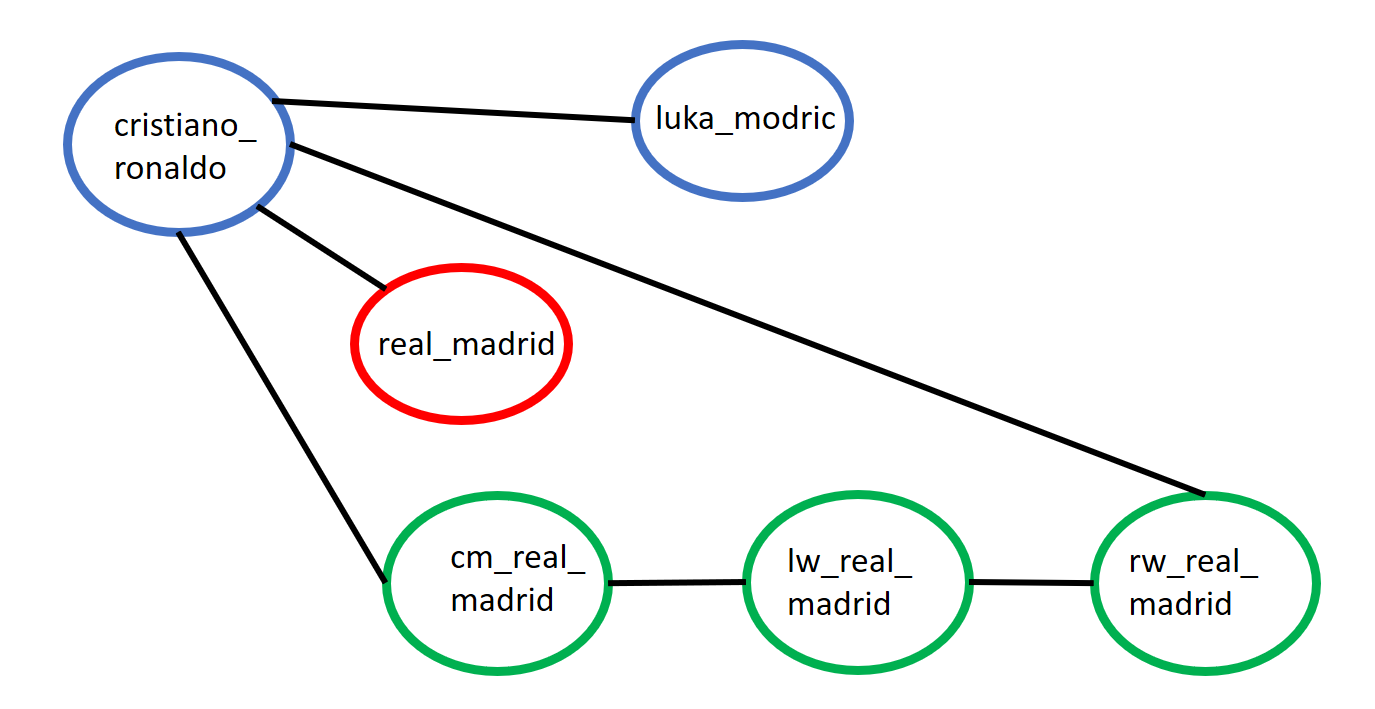

In [ ]:
#Image("Football4.png")

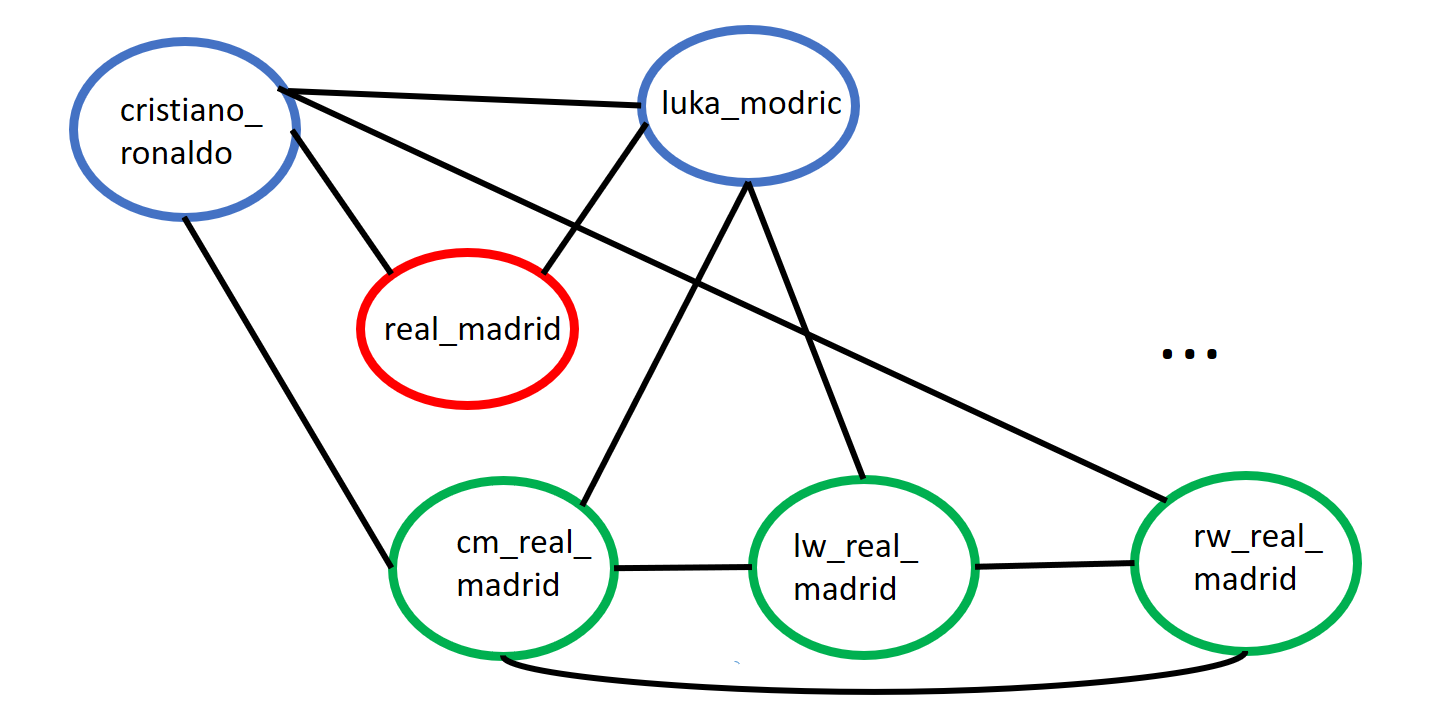

In [ ]:
#Image("Football5.png")

### Teams Mapping

In [ ]:
teams = [('real_madrid', '4-3-3_4'), 
         ('chelsea', '5-2-2-1'),
         ('manchester_utd', '4-3-3_2'),
         ('manchester_city', '4-3-3_2'),
         ('juventus', '4-2-3-1_2'),
         ('fc_bayern', '4-2-3-1_2'),
         ('napoli', '4-3-3')]

In [ ]:
# create graph for a specific team
graph = club2graph('real_madrid', '4-3-3_4', graph)

In [ ]:
# 7 graphs (each for team)
for team, formation in teams:
    graph = club2graph(team, formation, graph)

### Node2Vec

In [ ]:
node2vec = Node2Vec(graph, dimensions=20, walk_length=16, num_walks=100, workers=2)

In [ ]:
fix_formatted_positions = lambda x: x.split('_')[0] if x in formatted_positions else x
reformatted_walks = [list(map(fix_formatted_positions, walk)) for walk in node2vec.walks]
node2vec.walks = reformatted_walks

In [ ]:
model = node2vec.fit(window=10, min_count=1)

## Most similar nodes

In [ ]:
for node, _ in model.most_similar('rw'):
    # Show only players
    if len(node) > 3:
        print(node)

pedro
gareth_bale
n'golo_kante
henrikh_mkhitaryan
james_rodriguez
diego_costa
carvajal


In [ ]:
for node, _ in model.most_similar('gk'):
    # Show only players
    if len(node) > 3:
        print(node)

thibaut_courtois
manuel_neuer
gianluigi_buffon
gary_cahill
azpilicueta
david_luiz
chelsea


In [ ]:
for node, _ in model.most_similar('real_madrid'):
    print(node)

james_rodriguez
toni_kroos
pepe
sergio_ramos
karim_benzema
keylor_navas
marcelo
cristiano_ronaldo
luka_modric
carvajal


In [ ]:
for node, _ in model.most_similar('paulo_dybala'):
    print(node)

gonzalo_higuain
juan_cuadrado
mario_mandzukic
juventus
alex_sandro
stephan_lichtsteiner
miralem_pjanic
sami_khedira
leonardo_bonucci
giorgio_chiellini


## Visualization of the teams

In [ ]:
player_nodes = [x for x in model.wv.vocab if len(x) > 3 and x not in clubs]
embeddings = np.array([model.wv[x] for x in player_nodes])

In [ ]:
tsne = TSNE(n_components=2, random_state=7, perplexity=15)
embeddings_2d = tsne.fit_transform(embeddings)

In [ ]:
# Assign colors to players
team_colors = {
    'real_madrid': 'lightblue',
    'chelsea': 'b',
    'manchester_utd': 'r',
    'manchester_city': 'teal',
    'juventus': 'gainsboro',
    'napoli': 'deepskyblue',
    'fc_bayern': 'tomato' 
}

data['color'] = data['club'].apply(lambda x: team_colors[x])
player_colors = dict(zip(data['name'], data['color']))
colors = [player_colors[x] for x in player_nodes]

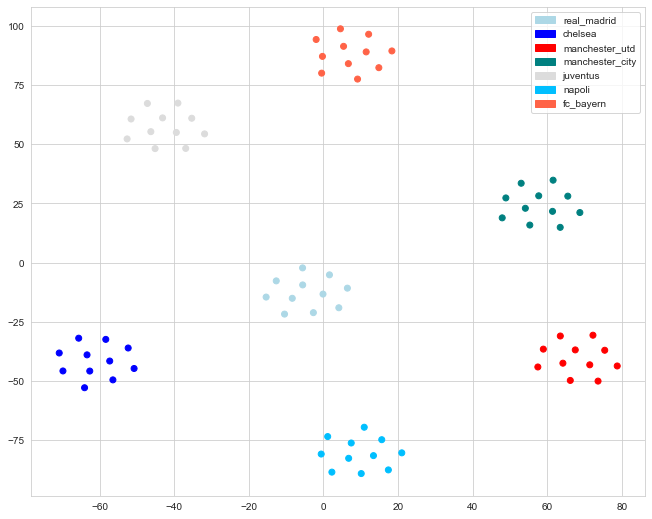

In [ ]:
figure = plt.figure(figsize=(11, 9))

ax = figure.add_subplot(111)

ax.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=colors)

# Create team patches for legend
team_patches = [mpatches.Patch(color=color, label=team) for team, color in team_colors.items()]
ax.legend(handles=team_patches);